# Convolutional Neural Networks

## Project: Dog - Human Identification and Dog breeds classification 

---


### The Road Ahead

The notebook is broken into different steps.  

* 1- Import Datasets
* 2- Detect Humans
* 3- Detect Dogs
* 4- Create a CNN to Classify Dog Breeds (from Scratch)
* 5- Create a CNN to Classify Dog Breeds (using Transfer Learning)
* 6- This is a human and looks like a ...!

---


<a id='step0'></a>
## Step 1: Import Datasets

Make sure that you've downloaded the required human and dog datasets:


* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [68]:
import numpy as np
from glob import glob
import cv2
# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 2: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 0


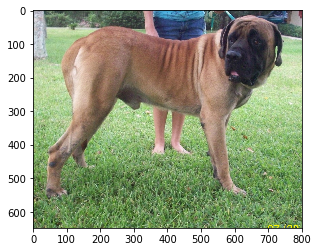

In [69]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(dog_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

### Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [70]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [71]:
face_detector(human_files[1])

True

### Assess the Human Face Detector


Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

In [72]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]



H1=0
D1=0
for i in range(100):
    if face_detector(human_files_short[i]):
        H1+=1
    if face_detector(dog_files_short[i]):
        D1+=1
print('Percentage of detected human face in Human images: %',H1)
print('Percentage of detected human face in Dog images: %',D1)



Percentage of detected human face in Human images: % 98
Percentage of detected human face in Dog images: % 17


---
<a id='step2'></a>
## Step 3: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [73]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()
    

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### Making Predictions with a Pre-trained Model

In the next code cell, you will see a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

You could learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [74]:
from PIL import Image
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
   
    
    im=Image.open(img_path)
    in_transform = transforms.Compose([
                        transforms.Resize((224, 224)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    
    
    image = in_transform(im)[:3,:,:].unsqueeze(0)
    #print(image.shape)
    image=image.cuda()
    output = VGG16(image)
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.cpu().numpy())
   
    
    return preds # predicted class index

In [75]:
import pickle

Predicted_classindex=VGG16_predict(dog_files[0])
print(Predicted_classindex)

#The Class_indes.pkl is created and uploaded separately.
with open('Class_index.pkl', 'rb') as f:
    Class_index = pickle.load(f)

print(Class_index[int(Predicted_classindex)])


243
bull mastiff


###  Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [76]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    Predicted_classindex = VGG16_predict(img_path)
    if Predicted_classindex > 150 and Predicted_classindex < 269:
        return True
    return False # true/false

In [77]:
print(dog_detector(dog_files[0]))
print(dog_detector(human_files[0]))

True
False


###  Assess the Dog Detector


In [45]:

H1=0
D1=0

for i in range(100):
    if dog_detector(human_files_short[i]):
        H1+=1
    if dog_detector(dog_files_short[i]):
        D1+=1
print('Percentage of detected human face in Human images using "dog_detector": %',H1)
print('Percentage of detected human face in Dog images using "dog_detector": %',D1)



Percentage of detected human face in Human images using "dog_detector": % 2
Percentage of detected human face in Dog images using "dog_detector": % 100


---
<a id='step3'></a>
## Step 4: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  

### Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [49]:
import os
from torchvision import datasets
import torchvision.transforms as transforms
import torch
import numpy as np
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

use_cuda = torch.cuda.is_available()


batch_size = 20
num_workers = 0

data_dir = '/home/sebi/Desktop/Udacity/dogImages'

train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')

dim=224


data_transforms = {'train': transforms.Compose([
                                     transforms.Resize(dim),
                                     transforms.transforms.RandomResizedCrop(dim),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomRotation(5),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                              std=[0.5, 0.5, 0.5])]),
                   'val': transforms.Compose([transforms.Resize(dim),
                                     transforms.CenterCrop(dim),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                              std=[0.5, 0.5, 0.5])]),
                   'test': transforms.Compose([transforms.Resize(size=(dim,dim)),
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                              std=[0.5, 0.5, 0.5])])
                  }


train_data = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
valid_data = datasets.ImageFolder(valid_dir, transform=data_transforms['val'])
test_data = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=False)


In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

# A function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

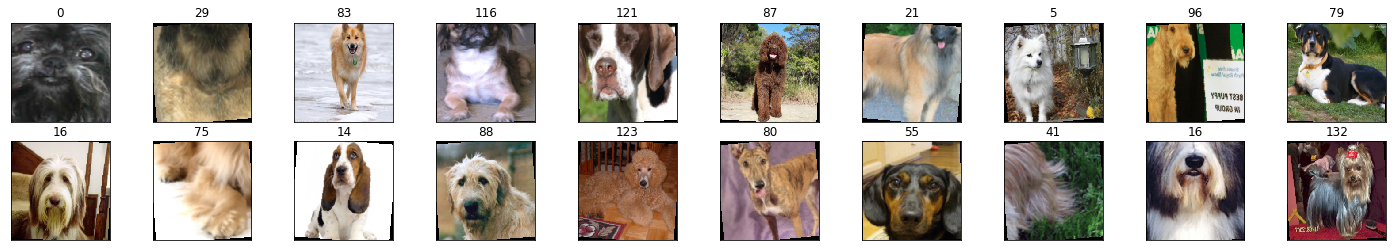

In [51]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

#plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(labels[idx].numpy())

###  Model Architecture

A CNN to classify dog breed.  

In [52]:
#use_cuda=False
import torch.nn as nn
import torch.nn.functional as F
    
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        # convolutional layer (sees 224x224x3 image tensor)
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1)
        # convolutional layer (sees 112x112x16 tensor)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        # convolutional layer (sees 56x56x32 tensor)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 14 * 14 -> 500)
        self.fc1 = nn.Linear(128*7*7, 500)
        # linear layer (500 -> 113)
        self.fc2 = nn.Linear(500, 133)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        ## Define forward behavior
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 128 * 7*7)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, without activation function
        x = self.fc2(x)
        return x



# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()
print(model_scratch)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=133, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


###  Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [53]:
import torch.optim as optim


criterion_scratch = nn.CrossEntropyLoss()
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.05)

###  Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [54]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss

        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):

            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            optimizer.zero_grad()
            
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + (1 / (batch_idx + 1)) * (loss.data - train_loss)
            #print(train_loss)
            
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            
            output = model(data)
            
          
            loss = criterion(output, target)
            valid_loss = valid_loss + (1 / (batch_idx + 1)) * (loss.data - valid_loss)
            
  
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        

        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        
        
            
    # return trained model
    return model


#model_scratch.load_state_dict(torch.load('model_Dog.pt'))

In [55]:
# Train the model
loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

model_scratch = train(50, loaders_scratch, model_scratch, optimizer_scratch,criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 4.880664 	Validation Loss: 4.862401
Validation loss decreased (inf --> 4.862401).  Saving model ...
Epoch: 2 	Training Loss: 4.830330 	Validation Loss: 4.744045
Validation loss decreased (4.862401 --> 4.744045).  Saving model ...
Epoch: 3 	Training Loss: 4.754858 	Validation Loss: 4.662621
Validation loss decreased (4.744045 --> 4.662621).  Saving model ...
Epoch: 4 	Training Loss: 4.658994 	Validation Loss: 4.520788
Validation loss decreased (4.662621 --> 4.520788).  Saving model ...
Epoch: 5 	Training Loss: 4.572715 	Validation Loss: 4.415629
Validation loss decreased (4.520788 --> 4.415629).  Saving model ...
Epoch: 6 	Training Loss: 4.533133 	Validation Loss: 4.357555
Validation loss decreased (4.415629 --> 4.357555).  Saving model ...
Epoch: 7 	Training Loss: 4.488768 	Validation Loss: 4.334033
Validation loss decreased (4.357555 --> 4.334033).  Saving model ...
Epoch: 8 	Training Loss: 4.443670 	Validation Loss: 4.305195
Validation loss decreased (4.33403

<All keys matched successfully>

###  Test the Model

Use the code cell below to calculate and print the test loss and accuracy.  

In [56]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function
loaders_scratch={'test': test_loader}
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.469190


Test Accuracy: 19% (161/836)


---
<a id='step4'></a>
## Step 5: A CNN to Classify Dog Breeds (using Transfer Learning)

We will now use transfer learning to create a CNN that can identify dog breed from images.  Our CNN must attain at least 60% accuracy on the test set.

### Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 



In [78]:
import os
from torchvision import datasets
import torchvision.transforms as transforms
import torch
import numpy as np
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

use_cuda = torch.cuda.is_available()

batch_size = 20
num_workers = 0

#data_dir = '/home/sebi/Desktop/Udacity/dogImages'
data_dir = '/data/dog_images/'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')

dim=224


data_transforms = {'train': transforms.Compose([
                                     transforms.Resize(dim),
                                     transforms.transforms.RandomResizedCrop(dim),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomRotation(5),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                              std=[0.5, 0.5, 0.5])]),
                   'val': transforms.Compose([transforms.Resize(dim),
                                     transforms.CenterCrop(dim),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                              std=[0.5, 0.5, 0.5])]),
                   'test': transforms.Compose([transforms.Resize(size=(dim,dim)),
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                              std=[0.5, 0.5, 0.5])])
                  }


train_data = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
valid_data = datasets.ImageFolder(valid_dir, transform=data_transforms['val'])
test_data = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=False)


### Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [80]:
import torchvision.models as models
import torch.nn as nn

use_cuda = torch.cuda.is_available()

# Load the pretrained model from pytorch
model_transfer = models.vgg16(pretrained=True)

# print out the model structure
#print(model_transfer)

if use_cuda:
    model_transfer = model_transfer.cuda()

In [81]:
# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False

In [82]:
import torch.nn as nn

classes=133

n_inputs = model_transfer.classifier[6].in_features

# add last linear layer (n_inputs -> 5 flower classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, classes)

model_transfer.classifier[6] = last_layer

# if GPU is available, move the model to GPU
if use_cuda:
    model_transfer.cuda()

# check to see that your last layer produces the expected number of outputs
#print(model_transfer.classifier[6].out_features)
print(model_transfer)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

### Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [83]:
import torch.optim as optim
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.001)

### Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [7]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss

        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):

            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            optimizer.zero_grad()
            
            output = model(data)
           # print(output.shape)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + (1 / (batch_idx + 1)) * (loss.data - train_loss)
            #print(train_loss)
            
            
        ######################    
        # validate the model #
        ######################
       # print('validation')
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            #print(data.shape)
            
            output = model(data)
            
            
            
            loss = criterion(output, target)
            valid_loss = valid_loss + (1 / (batch_idx + 1)) * (loss.data - valid_loss)
            
  
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        

        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        
        
            
    # return trained model
    return model



In [8]:
# train the model
loaders_transfer = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

model_transfer =  train(20, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 4.483551 	Validation Loss: 3.415617
Validation loss decreased (inf --> 3.415617).  Saving model ...
Epoch: 2 	Training Loss: 3.377575 	Validation Loss: 1.860884
Validation loss decreased (3.415617 --> 1.860884).  Saving model ...
Epoch: 3 	Training Loss: 2.516429 	Validation Loss: 1.146189
Validation loss decreased (1.860884 --> 1.146189).  Saving model ...
Epoch: 4 	Training Loss: 2.085856 	Validation Loss: 0.870073
Validation loss decreased (1.146189 --> 0.870073).  Saving model ...
Epoch: 5 	Training Loss: 1.863934 	Validation Loss: 0.744968
Validation loss decreased (0.870073 --> 0.744968).  Saving model ...
Epoch: 6 	Training Loss: 1.720139 	Validation Loss: 0.678601
Validation loss decreased (0.744968 --> 0.678601).  Saving model ...
Epoch: 7 	Training Loss: 1.609291 	Validation Loss: 0.633419
Validation loss decreased (0.678601 --> 0.633419).  Saving model ...
Epoch: 8 	Training Loss: 1.555656 	Validation Loss: 0.599080
Validation loss decreased (0.63341

###  Test the Model

Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [8]:

def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function
loaders_transfer = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

model_transfer.load_state_dict(torch.load('model_transfer.pt'))
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.604762


Test Accuracy: 81% (685/836)


In [84]:
loaders_transfer = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### Predict Dog Breed with the Model

This function takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by the model.  

The predicted dog breed is : Bullmastiff


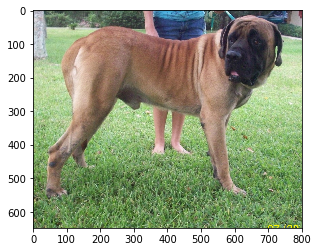

In [85]:

# list of class names by index, i.e. a name can be accessed like class_names[0]
#train_loader.dataset.classes
import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt                        
%matplotlib inline   
import torchvision.transforms as transforms

class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]


def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    im=Image.open(img_path)
    in_transform = transforms.Compose([
                        transforms.Resize((224, 224)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), 
                                             (0.5, 0.5, 0.5))])

    
    
    image = in_transform(im)[:3,:,:].unsqueeze(0)

    image=image.cuda()
    output = model_transfer(image)
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.cpu().numpy())
   
    
    return im,preds # predicted class index

dog_files = np.array(glob("/data/dog_images/*/*/*"))
img_path = dog_files[0]
im, PredictedBreed = predict_breed_transfer(img_path)
plt.imshow(im)
print('The predicted dog breed is :',class_names[PredictedBreed])

---
<a id='step5'></a>
## Step 6: This is a human and looks like a ...!

We write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.



In [86]:

def run_app(img_path):
    
    if dog_detector(img_path):
        im, B= predict_breed_transfer(img_path)
        plt.figure()
        plt.imshow(im)
        print('The predicted dog breed is :',class_names[B])

    elif face_detector(img_path):
        
        im, B= predict_breed_transfer(img_path)
        plt.figure()
        plt.imshow(im)
        print('This is a human and looks like a ... :',class_names[B])
   
    else:
         print('There is an error!')
    ## handle cases for a human face, dog, and neither
    


---
<a id='step6'></a>
##  Test the Algorithm

What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?



This is a human and looks like a ... : Poodle
This is a human and looks like a ... : English toy spaniel
This is a human and looks like a ... : French bulldog
The predicted dog breed is : Mastiff
The predicted dog breed is : Anatolian shepherd dog
The predicted dog breed is : Cane corso


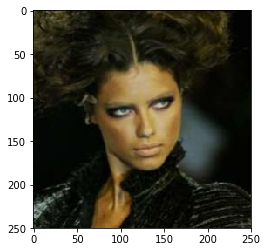

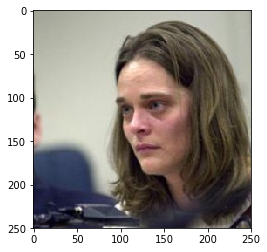

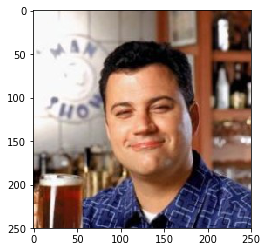

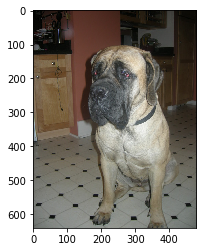

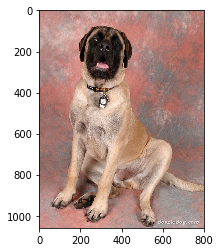

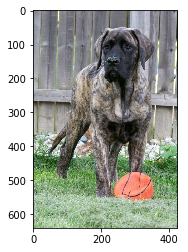

In [89]:

for file in np.hstack((human_files[20:23], dog_files[20:23])):
    run_app(file)